# Segment Anything Model (SAM)

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/facebookresearch/segment-anything) [![arXiv](https://img.shields.io/badge/arXiv-2304.02643-b31b1b.svg)](https://arxiv.org/abs/2304.02643)

Segment Anything Model (SAM): a new AI model from Meta AI that can "cut out" any object, in any image, with a single click. SAM is a promptable segmentation system with zero-shot generalization to unfamiliar objects and images, without the need for additional training. This notebook is an extension of the [official notebook](https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb) prepared by Meta AI.

![segment anything model](https://media.roboflow.com/notebooks/examples/segment-anything-model-paper.png)

## Complementary Materials

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-anything-with-sam.ipynb) [![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/D-D6ZmadzPE) [![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/how-to-use-segment-anything-model-sam)

## Steps

- Install Segment Anything Model (SAM)
- Download Example Data
- Load Model
- Automated Mask Generation
- Generate Segmentation with Bounding Box

In [17]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: c:\Users\julia\Desktop\Development\AI\CropVest


## Install Segment Anything Model (SAM) and other dependencies

In [ ]:
! pip install -q jupyter_bbox_widget dataclasses-json supervision
! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
! pip install 'git+https://github.com/facebookresearch/segment-anything.git' 

### Download SAM weights

In [18]:
import os
CHECKPOINT_PATH = os.path.join("weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

weights\sam_vit_h_4b8939.pth ; exist: True


## Load Model

In [19]:
import torch
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [20]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [21]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [22]:
import os

IMAGE_NAME = "photo_2023-08-13_01-45-43.jpg"
IMAGE_PATH = os.path.join(HOME, "satellite_data", IMAGE_NAME)

### Generate masks with SAM

Create onnx format of model

In [23]:
!pip -q install torch torchvision onnx
using_colab = True
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install matplotlib onnx onnxruntime 


#opencv-python

PyTorch version: 2.0.1+cu117
Torchvision version: 0.15.2+cu117
CUDA is available: False


In [24]:
import torch
import numpy as np
import cv2
import warnings
import matplotlib.pyplot as plt
# sam
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.onnx import SamOnnxModel
# onnx
import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    #ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

# main data for SAM model
checkpoint = "weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=checkpoint)
onnx_model_path = "sam_onnx.onnx"
onnx_model = SamOnnxModel(sam, return_single_mask=True)
# Point for single mask 
dynamic_axes = {
    "point_coords": {1: "num_points"},
    "point_labels": {1: "num_points"},
}

# shape definitions 
embed_dim = sam.prompt_encoder.embed_dim
embed_size = sam.prompt_encoder.image_embedding_size
mask_input_size = [4 * x for x in embed_size]
dummy_inputs = {
    "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
    "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
    "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
    "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
    "has_mask_input": torch.tensor([1], dtype=torch.float),
    "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
}
output_names = ["masks", "iou_predictions", "low_res_masks"]

# Warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    with open(onnx_model_path, "wb") as f:
        torch.onnx.export(
            onnx_model,
            tuple(dummy_inputs.values()),
            f,
            export_params=True,
            verbose=False,
            opset_version=17,
            do_constant_folding=True,
            input_names=list(dummy_inputs.keys()),
            output_names=output_names,
            dynamic_axes=dynamic_axes,
        )

onnx_model_quantized_path = "sam_onnx_quantized.onnx"
quantize_dynamic(
    model_input=onnx_model_path,
    model_output=onnx_model_quantized_path,
    optimize_model=True,
    per_channel=False,
    reduce_range=False,
    weight_type=QuantType.QUInt8,
)
onnx_model_path = onnx_model_quantized_path

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image/MatMul]

In [30]:
!git clone https://github.com/facebookresearch/segment-anything.git

Cloning into 'segment-anything'...


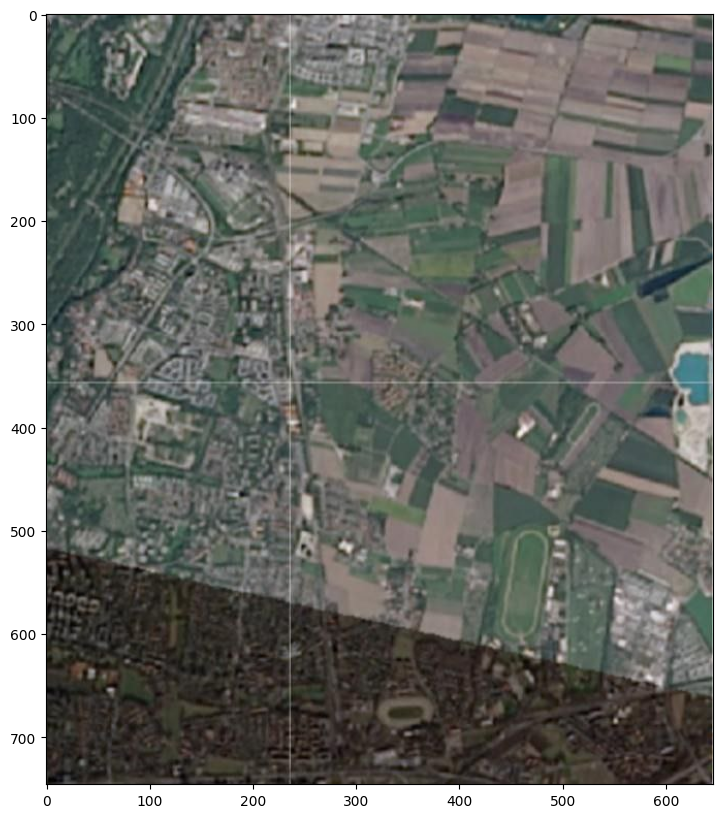

In [25]:
# Load image 
image = cv2.imread('satellite_data\photo_2023-08-13_01-45-43.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [26]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Generate some sample data (replace this with your actual data)
average_values = np.array([[150, 120, 80],  # Average channel values for a crop field based on colour
                           [130, 110, 75],
                           [170, 140, 90]])

crop_yield = np.array([300, 250, 350])  # Crop yield corresponding to each crop field based on colour

# Create a Linear Regression model
model = LinearRegression()

# Fit the model with the data
model.fit(average_values, crop_yield)

# Predict the crop yield for a new average channel value
new_average_value = np.array([[160, 130, 85]])  # Replace with your new average channel value
predicted_yield = model.predict(new_average_value)

# Print the predicted crop yield
print(f"Predicted Crop Yield: {predicted_yield[0]}")

Predicted Crop Yield: 324.99999999999994


(746, 646, 3)


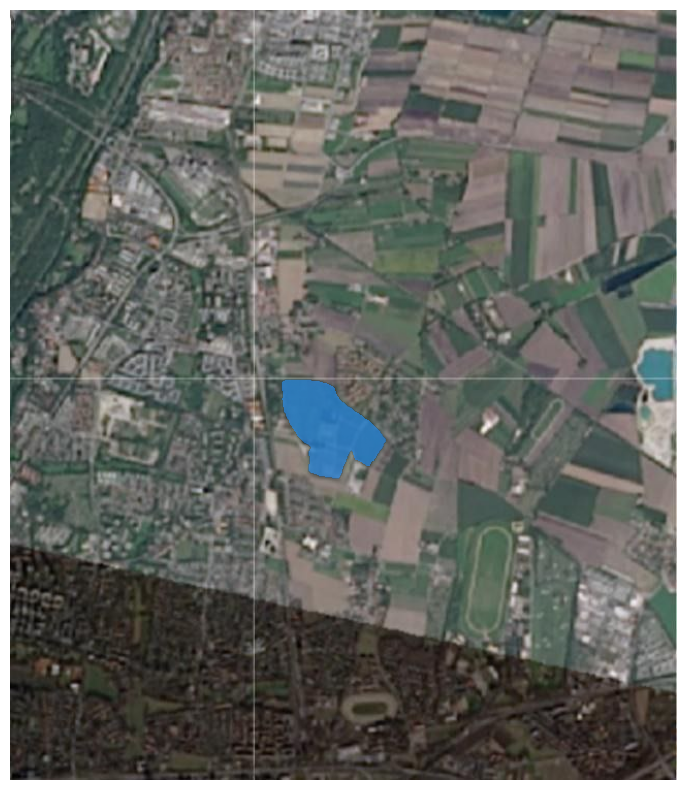

In [45]:
ort_session = onnxruntime.InferenceSession(onnx_model_path)

sam.to(device='cpu')
predictor = SamPredictor(sam)

predictor.set_image(image)

image_embedding = predictor.get_image_embedding().cpu().numpy()
#print(image_embedding)

#print(image_embedding.shape)

# Save the image embedding as an NPY file
np.save('image_embedding.npy', image_embedding)

print(image.shape)
input_point = np.array([[280, 405]])#[435, 350]#[405, 280] # B, H
input_label = np.array([1])

onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)


onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)



ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}


masks, _, low_res_logits = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold

masks.shape

plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

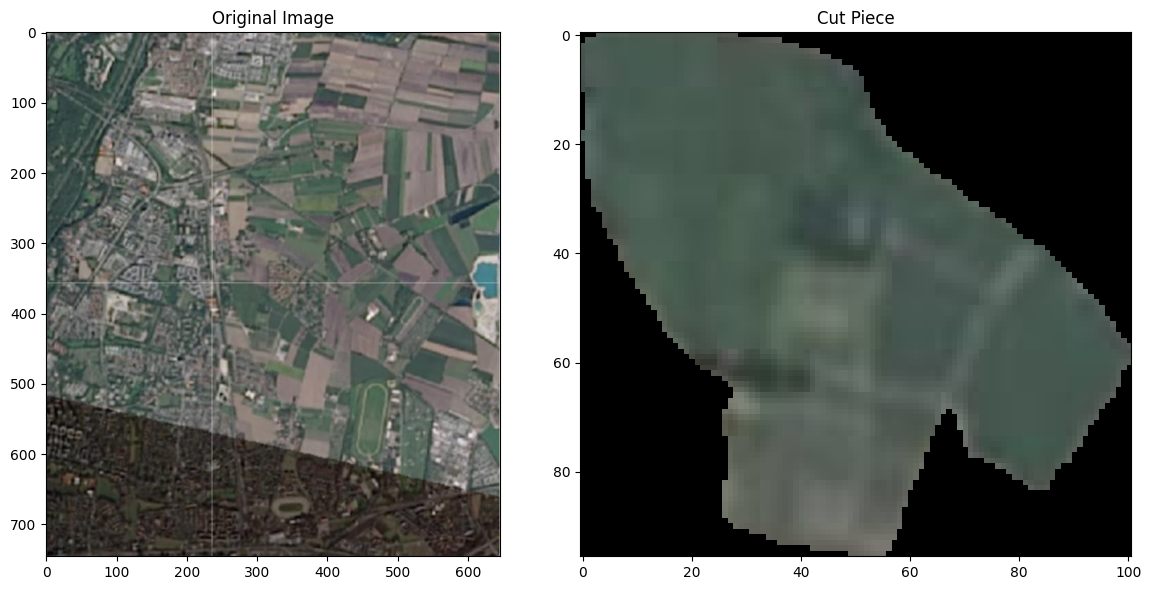

Average Channel Values:
Red: 46.35798267326733
Green: 55.06167491749175
Blue: 49.83034240924093
Classification: corn
Average Channel Value: 50.416666666666664


In [46]:
import onnxruntime
import numpy as np
import matplotlib.pyplot as plt

# Load the ONNX model
ort_session = onnxruntime.InferenceSession(onnx_model_path)

# Run inference
masks, _, low_res_logits = ort_session.run(None, ort_inputs)
masks = masks[0] > predictor.model.mask_threshold  # Remove the extra dimension

# Ensure masks and image have the same shape
if masks.shape[:2] != image.shape[:2]:
    masks = np.resize(masks, image.shape[:2])

# Apply mask to the image
masked_image = image.copy()
masked_image[~masks] = [0, 0, 0]  # Set masked regions to black

# Get bounding box of the mask
y_indices, x_indices = np.where(masks)
min_x, max_x = np.min(x_indices), np.max(x_indices)
min_y, max_y = np.min(y_indices), np.max(y_indices)

# Extract the cut piece
cut_piece = masked_image[min_y:max_y+1, min_x:max_x+1, :]

# Display the original image with the cut piece
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(cut_piece)
plt.title("Cut Piece")

plt.tight_layout()
plt.show()

# Calculate the average value of each channel of the cutted image
average_values = np.mean(cut_piece, axis=(0, 1))

# Print the average values
print("Average Channel Values:")
print(f"Red: {average_values[0]}")
print(f"Green: {average_values[1]}")
print(f"Blue: {average_values[2]}")

# Classify the cut piece based on average channel values
if average_values[0] > 20 and average_values[1] < 100 and average_values[2] < 150:
    classification = "corn"
elif average_values[0] > 50 and average_values[1] > 15 and average_values[2] < 100:
    classification = "wheat"
elif average_values[0] < 100 and average_values[1] > 10 and average_values[2] > 10:
    classification = "rice"
else:
    classification = "corn"

print(f"Classification: {classification}")

avg= np.mean(average_values)
print("Average Channel Value:",avg)

In [29]:
#Our prediction
predicted_yield = model.predict(average_values.reshape(1, -1))

# Print the predicted crop yield
print(f"Predicted Crop Yield: {predicted_yield[0]}")

Predicted Crop Yield: 168.50761862596045


### Output format

In [31]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [ ]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

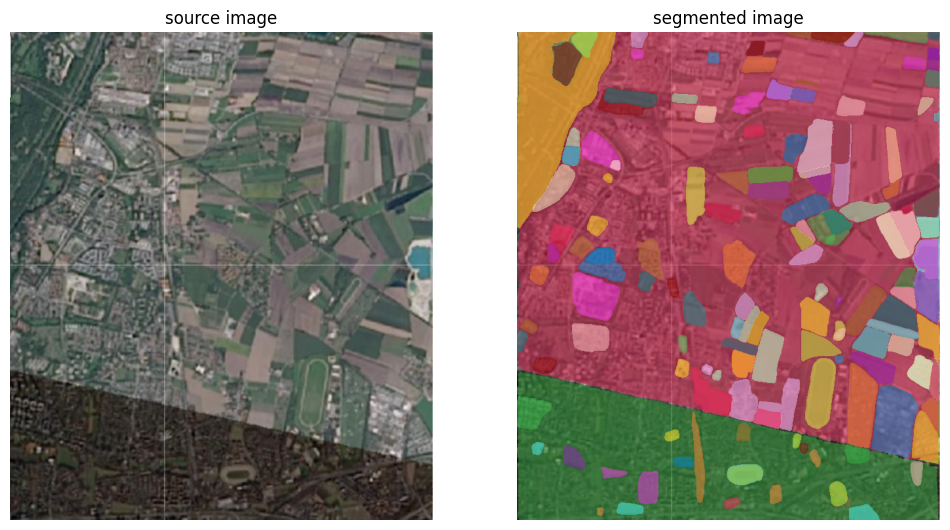

Annotated image saved as annotated_image.png


In [33]:
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

import cv2

# Assuming 'annotated_image' contains the annotated image obtained from the previous code
# You may need to adjust the file path as needed
output_path = "annotated_image.png"

# Save the annotated image as a PNG file
cv2.imwrite(output_path, annotated_image)

print("Annotated image saved as", output_path)

### Interaction with segmentation results

In [ ]:
# Not working with satellite images as we have to many masks :(
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(8, int(len(masks) / 8)),
    size=(16, 16)
)

## Generate Segmentation with Bounding Box

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [ ]:
mask_predictor = SamPredictor(sam)

In [ ]:
import os

IMAGE_NAME = "Farm_Image.jpg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

### Draw Box



In [ ]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 292, 'y': 147, 'width': 318, 'height': 289, 'label': ''}]

### Generate masks with SAM

**NOTE:** `SamPredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format. Let's reorganise your data first

In [ ]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [ ]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

### Results visualisation with Supervision

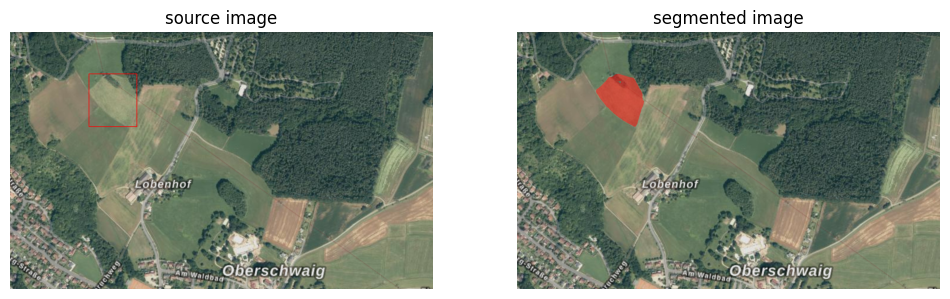

In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

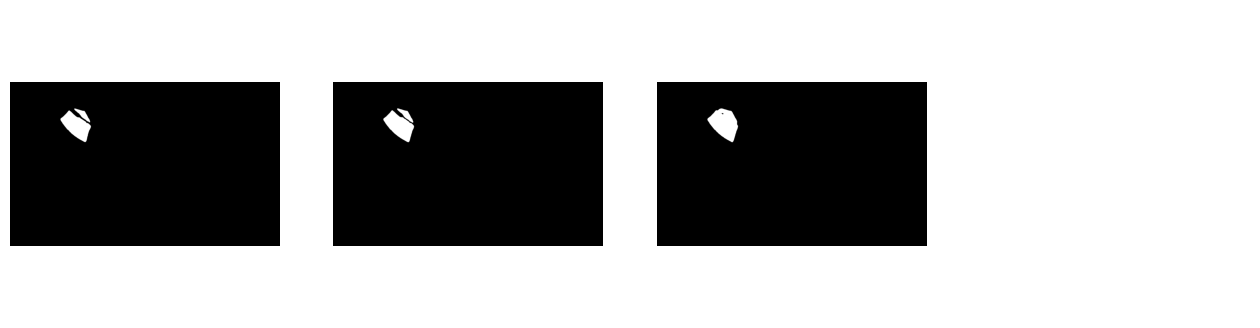

In [ ]:
import supervision as v

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)